In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


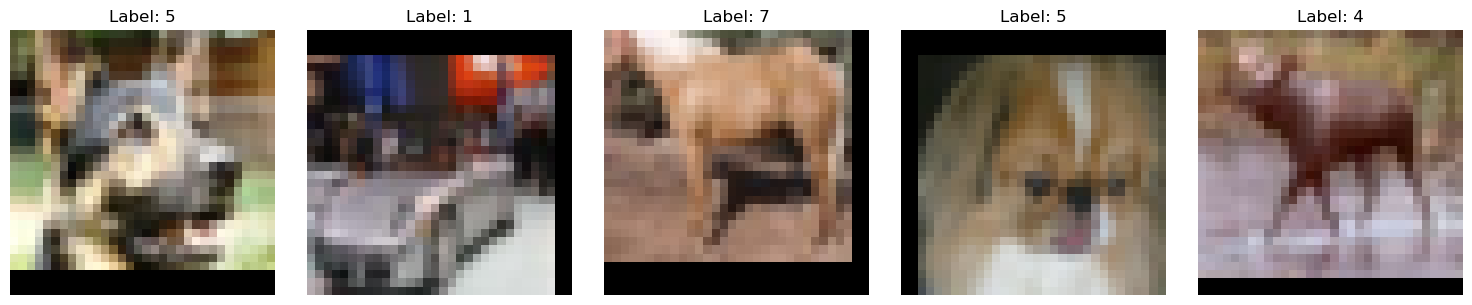

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:51<00:00,  6.83it/s]


Epoch 1 => Train Loss: 1.4378, Acc: 0.4659 | Val Loss: 1.2863, Acc: 0.5698


Epoch 2/100: 100%|██████████| 352/352 [00:51<00:00,  6.85it/s]


Epoch 2 => Train Loss: 0.9781, Acc: 0.6484 | Val Loss: 1.1158, Acc: 0.6380


Epoch 3/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 3 => Train Loss: 0.7740, Acc: 0.7277 | Val Loss: 0.7980, Acc: 0.7316


Epoch 4/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 4 => Train Loss: 0.6365, Acc: 0.7764 | Val Loss: 0.6977, Acc: 0.7596


Epoch 5/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 5 => Train Loss: 0.5522, Acc: 0.8085 | Val Loss: 0.5980, Acc: 0.8024


Epoch 6/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 6 => Train Loss: 0.4907, Acc: 0.8318 | Val Loss: 0.5351, Acc: 0.8198


Epoch 7/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 7 => Train Loss: 0.4373, Acc: 0.8478 | Val Loss: 0.4776, Acc: 0.8414


Epoch 8/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 8 => Train Loss: 0.4016, Acc: 0.8614 | Val Loss: 0.4753, Acc: 0.8422


Epoch 9/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 9 => Train Loss: 0.3650, Acc: 0.8738 | Val Loss: 0.4460, Acc: 0.8496


Epoch 10/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 10 => Train Loss: 0.3308, Acc: 0.8853 | Val Loss: 0.4337, Acc: 0.8552


Epoch 11/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 11 => Train Loss: 0.3079, Acc: 0.8957 | Val Loss: 0.3700, Acc: 0.8686


Epoch 12/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 12 => Train Loss: 0.2812, Acc: 0.9032 | Val Loss: 0.4318, Acc: 0.8656


Epoch 13/100: 100%|██████████| 352/352 [00:50<00:00,  6.96it/s]


Epoch 13 => Train Loss: 0.2625, Acc: 0.9098 | Val Loss: 0.4549, Acc: 0.8554


Epoch 14/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 14 => Train Loss: 0.2458, Acc: 0.9150 | Val Loss: 0.3914, Acc: 0.8708


Epoch 15/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 15 => Train Loss: 0.2219, Acc: 0.9230 | Val Loss: 0.4257, Acc: 0.8692


Epoch 16/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 16 => Train Loss: 0.2097, Acc: 0.9260 | Val Loss: 0.3902, Acc: 0.8782


Epoch 17/100: 100%|██████████| 352/352 [00:51<00:00,  6.83it/s]


Epoch 17 => Train Loss: 0.1876, Acc: 0.9344 | Val Loss: 0.3877, Acc: 0.8820


Epoch 18/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 18 => Train Loss: 0.1824, Acc: 0.9355 | Val Loss: 0.3429, Acc: 0.8906


Epoch 19/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 19 => Train Loss: 0.1666, Acc: 0.9430 | Val Loss: 0.3823, Acc: 0.8860


Epoch 20/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 20 => Train Loss: 0.1558, Acc: 0.9442 | Val Loss: 0.3519, Acc: 0.8948


Epoch 21/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 21 => Train Loss: 0.1470, Acc: 0.9482 | Val Loss: 0.3422, Acc: 0.8998


Epoch 22/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 22 => Train Loss: 0.1353, Acc: 0.9527 | Val Loss: 0.3514, Acc: 0.8942


Epoch 23/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 23 => Train Loss: 0.1307, Acc: 0.9541 | Val Loss: 0.3482, Acc: 0.9020


Epoch 24/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 24 => Train Loss: 0.1183, Acc: 0.9574 | Val Loss: 0.3785, Acc: 0.8970


Epoch 25/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 25 => Train Loss: 0.1150, Acc: 0.9596 | Val Loss: 0.4212, Acc: 0.8898


Epoch 26/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 26 => Train Loss: 0.1095, Acc: 0.9608 | Val Loss: 0.3898, Acc: 0.8948


Epoch 27/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 27 => Train Loss: 0.1014, Acc: 0.9640 | Val Loss: 0.3960, Acc: 0.8970


Epoch 28/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 28 => Train Loss: 0.0971, Acc: 0.9663 | Val Loss: 0.3811, Acc: 0.8956


Epoch 29/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 29 => Train Loss: 0.0873, Acc: 0.9698 | Val Loss: 0.3773, Acc: 0.9028


Epoch 30/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 30 => Train Loss: 0.0876, Acc: 0.9691 | Val Loss: 0.3955, Acc: 0.8996


Epoch 31/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 31 => Train Loss: 0.0851, Acc: 0.9695 | Val Loss: 0.3862, Acc: 0.9042


Epoch 32/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 32 => Train Loss: 0.0783, Acc: 0.9724 | Val Loss: 0.4475, Acc: 0.8884


Epoch 33/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 33 => Train Loss: 0.0755, Acc: 0.9735 | Val Loss: 0.3975, Acc: 0.9072


Epoch 34/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 34 => Train Loss: 0.0706, Acc: 0.9745 | Val Loss: 0.4192, Acc: 0.9010


Epoch 35/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 35 => Train Loss: 0.0710, Acc: 0.9744 | Val Loss: 0.4020, Acc: 0.9086


Epoch 36/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 36 => Train Loss: 0.0642, Acc: 0.9775 | Val Loss: 0.3810, Acc: 0.9084


Epoch 37/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 37 => Train Loss: 0.0671, Acc: 0.9760 | Val Loss: 0.4282, Acc: 0.9034


Epoch 38/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 38 => Train Loss: 0.0636, Acc: 0.9774 | Val Loss: 0.3988, Acc: 0.9064


Epoch 39/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 39 => Train Loss: 0.0563, Acc: 0.9793 | Val Loss: 0.4128, Acc: 0.9122


Epoch 40/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 40 => Train Loss: 0.0615, Acc: 0.9780 | Val Loss: 0.3933, Acc: 0.9130


Epoch 41/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 41 => Train Loss: 0.0596, Acc: 0.9789 | Val Loss: 0.3914, Acc: 0.9092


Epoch 42/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 42 => Train Loss: 0.0568, Acc: 0.9801 | Val Loss: 0.4571, Acc: 0.9008


Epoch 43/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 43 => Train Loss: 0.0540, Acc: 0.9814 | Val Loss: 0.4163, Acc: 0.9108


Epoch 44/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 44 => Train Loss: 0.0499, Acc: 0.9824 | Val Loss: 0.4047, Acc: 0.9104


Epoch 45/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 45 => Train Loss: 0.0478, Acc: 0.9830 | Val Loss: 0.4400, Acc: 0.9076


Epoch 46/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 46 => Train Loss: 0.0531, Acc: 0.9813 | Val Loss: 0.4061, Acc: 0.9128


Epoch 47/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 47 => Train Loss: 0.0479, Acc: 0.9832 | Val Loss: 0.4664, Acc: 0.9044


Epoch 48/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 48 => Train Loss: 0.0467, Acc: 0.9838 | Val Loss: 0.4126, Acc: 0.9114


Epoch 49/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 49 => Train Loss: 0.0478, Acc: 0.9829 | Val Loss: 0.4318, Acc: 0.9094


Epoch 50/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 50 => Train Loss: 0.0445, Acc: 0.9846 | Val Loss: 0.4755, Acc: 0.9036


Epoch 51/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 51 => Train Loss: 0.0398, Acc: 0.9862 | Val Loss: 0.4285, Acc: 0.9080


Epoch 52/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 52 => Train Loss: 0.0424, Acc: 0.9854 | Val Loss: 0.4612, Acc: 0.9018


Epoch 53/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 53 => Train Loss: 0.0398, Acc: 0.9860 | Val Loss: 0.4887, Acc: 0.9014


Epoch 54/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 54 => Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.4874, Acc: 0.9028


Epoch 55/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 55 => Train Loss: 0.0414, Acc: 0.9853 | Val Loss: 0.4634, Acc: 0.9090


Epoch 56/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 56 => Train Loss: 0.0391, Acc: 0.9863 | Val Loss: 0.4843, Acc: 0.9038


Epoch 57/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 57 => Train Loss: 0.0412, Acc: 0.9859 | Val Loss: 0.4506, Acc: 0.9104


Epoch 58/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 58 => Train Loss: 0.0347, Acc: 0.9879 | Val Loss: 0.4426, Acc: 0.9052


Epoch 59/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 59 => Train Loss: 0.0372, Acc: 0.9874 | Val Loss: 0.4706, Acc: 0.9100


Epoch 60/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 60 => Train Loss: 0.0333, Acc: 0.9882 | Val Loss: 0.4280, Acc: 0.9140


Epoch 61/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 61 => Train Loss: 0.0295, Acc: 0.9895 | Val Loss: 0.4700, Acc: 0.9096


Epoch 62/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 62 => Train Loss: 0.0366, Acc: 0.9869 | Val Loss: 0.4593, Acc: 0.9080


Epoch 63/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 63 => Train Loss: 0.0360, Acc: 0.9872 | Val Loss: 0.5198, Acc: 0.9038


Epoch 64/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 64 => Train Loss: 0.0368, Acc: 0.9872 | Val Loss: 0.4917, Acc: 0.9046


Epoch 65/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 65 => Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.4717, Acc: 0.9094


Epoch 66/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 66 => Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.4454, Acc: 0.9132


Epoch 67/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 67 => Train Loss: 0.0332, Acc: 0.9879 | Val Loss: 0.4463, Acc: 0.9176


Epoch 68/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 68 => Train Loss: 0.0338, Acc: 0.9881 | Val Loss: 0.4449, Acc: 0.9138


Epoch 69/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 69 => Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.4887, Acc: 0.9114


Epoch 70/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 70 => Train Loss: 0.0306, Acc: 0.9893 | Val Loss: 0.4493, Acc: 0.9152


Epoch 71/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 71 => Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.4433, Acc: 0.9142


Epoch 72/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 72 => Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.4527, Acc: 0.9164


Epoch 73/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 73 => Train Loss: 0.0286, Acc: 0.9896 | Val Loss: 0.4633, Acc: 0.9092


Epoch 74/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 74 => Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.4658, Acc: 0.9112


Epoch 75/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 75 => Train Loss: 0.0281, Acc: 0.9902 | Val Loss: 0.4507, Acc: 0.9134


Epoch 76/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 76 => Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.4921, Acc: 0.9074


Epoch 77/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 77 => Train Loss: 0.0288, Acc: 0.9901 | Val Loss: 0.4723, Acc: 0.9142


Epoch 78/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 78 => Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.4819, Acc: 0.9118


Epoch 79/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 79 => Train Loss: 0.0284, Acc: 0.9900 | Val Loss: 0.4218, Acc: 0.9154


Epoch 80/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 80 => Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.4620, Acc: 0.9168


Epoch 81/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 81 => Train Loss: 0.0241, Acc: 0.9916 | Val Loss: 0.4578, Acc: 0.9160


Epoch 82/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 82 => Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.4536, Acc: 0.9146


Epoch 83/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 83 => Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.4637, Acc: 0.9150


Epoch 84/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 84 => Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.4346, Acc: 0.9196


Epoch 85/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 85 => Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.4512, Acc: 0.9164


Epoch 86/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 86 => Train Loss: 0.0275, Acc: 0.9904 | Val Loss: 0.4260, Acc: 0.9238


Epoch 87/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 87 => Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.4669, Acc: 0.9176


Epoch 88/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 88 => Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.4921, Acc: 0.9172


Epoch 89/100: 100%|██████████| 352/352 [00:51<00:00,  6.82it/s]


Epoch 89 => Train Loss: 0.0273, Acc: 0.9905 | Val Loss: 0.4379, Acc: 0.9168


Epoch 90/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 90 => Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.4636, Acc: 0.9166


Epoch 91/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 91 => Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.4474, Acc: 0.9172


Epoch 92/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 92 => Train Loss: 0.0248, Acc: 0.9912 | Val Loss: 0.4867, Acc: 0.9156


Epoch 93/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 93 => Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.4607, Acc: 0.9218


Epoch 94/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 94 => Train Loss: 0.0202, Acc: 0.9926 | Val Loss: 0.4666, Acc: 0.9210


Epoch 95/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 95 => Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.4330, Acc: 0.9220


Epoch 96/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 96 => Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.4517, Acc: 0.9166


Epoch 97/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 97 => Train Loss: 0.0193, Acc: 0.9931 | Val Loss: 0.4583, Acc: 0.9202


Epoch 98/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 98 => Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.4826, Acc: 0.9140


Epoch 99/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 99 => Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.4628, Acc: 0.9176


Epoch 100/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 100 => Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.5173, Acc: 0.9188


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adam_no_weight_decay.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

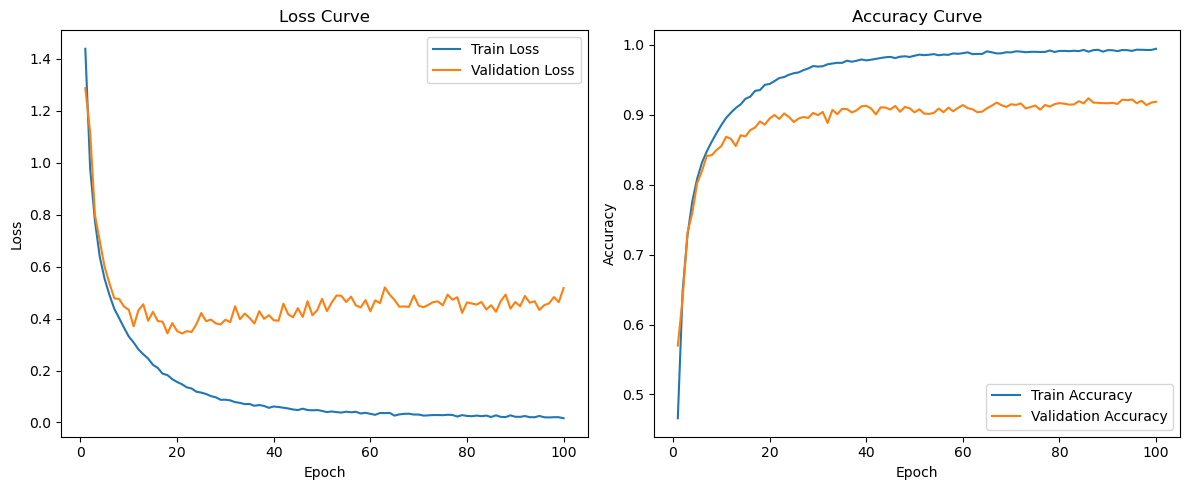

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [18]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.36%


In [17]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model1.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.23%
